In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [2]:
rawfeats = pd.read_csv('data/dengue_features_train.csv')
rawlabels = pd.read_csv('data/dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
iq = rawfeats[rawfeats.city=='iq']
print(iq.shape)
iq.head()

(520, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


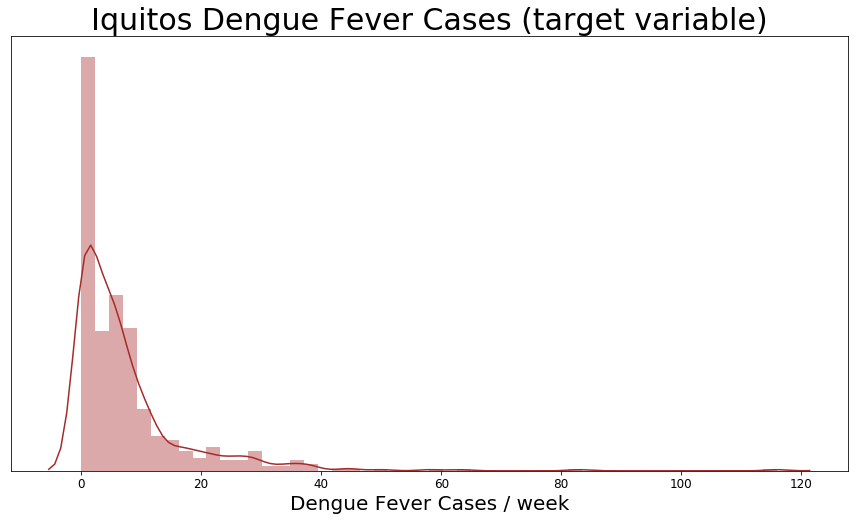

In [7]:
#outcome variable
plt.figure(figsize=[15,8])
sns.distplot(iq.total_cases, bins=50, color='brown')
plt.yticks([])
plt.xticks(size=12)
plt.title('Iquitos Dengue Fever Cases (target variable)', size=30)
plt.xlabel('Dengue Fever Cases / week', size=20)
plt.show()

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


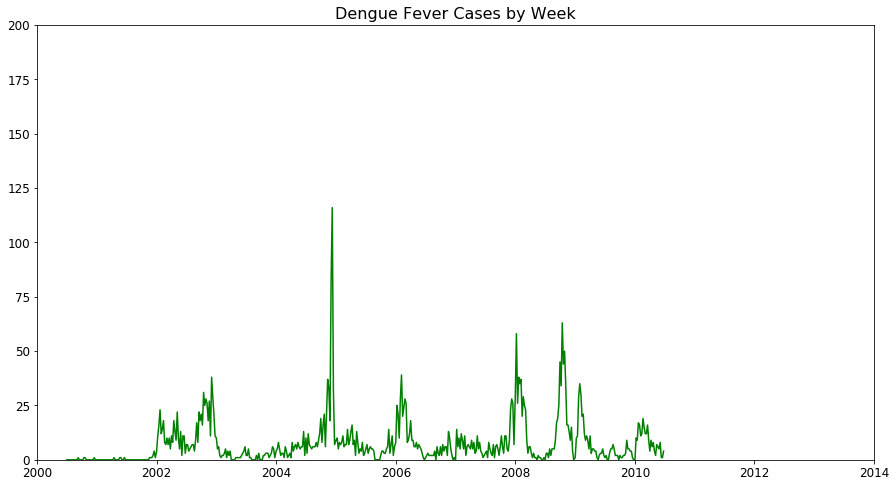

In [4]:
plt.figure(figsize=[15,8])
plt.title('Dengue Fever Cases by Week', size=16)
plt.plot(pd.to_datetime(iq.week_start_date), iq.total_cases, color='green')
plt.xlim(['2000-01-01','2013-12-31' ])
plt.ylim([0,200])
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [5]:
#corrected week of year
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2005,iq.weekofyear+1, iq.weekofyear)
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2006,iq.weekofyear_fixed+1, iq.weekofyear_fixed)
iq.loc[:,'weekofyear_fixed'] = np.where(iq.year==2010,iq.weekofyear_fixed+1, iq.weekofyear_fixed)
iq.loc[:,'weekofyear_fixed'] = np.where(iq.weekofyear_fixed>52,1, iq.weekofyear_fixed)
for year in iq.year.unique():
    print(f'{year} max: {max(iq[iq.year==year]["weekofyear_fixed"])}\
  | min: {min(iq[iq.year==year]["weekofyear_fixed"])}\
  | uniques: {iq[iq.year==year]["weekofyear_fixed"].nunique()}')
#Much better!

2000 max: 51  | min: 26  | uniques: 26
2001 max: 52  | min: 1  | uniques: 52
2002 max: 52  | min: 1  | uniques: 52
2003 max: 52  | min: 1  | uniques: 52
2004 max: 52  | min: 1  | uniques: 52
2005 max: 52  | min: 1  | uniques: 52
2006 max: 52  | min: 1  | uniques: 52
2007 max: 52  | min: 1  | uniques: 52
2008 max: 52  | min: 1  | uniques: 52
2009 max: 52  | min: 1  | uniques: 52
2010 max: 26  | min: 1  | uniques: 26


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


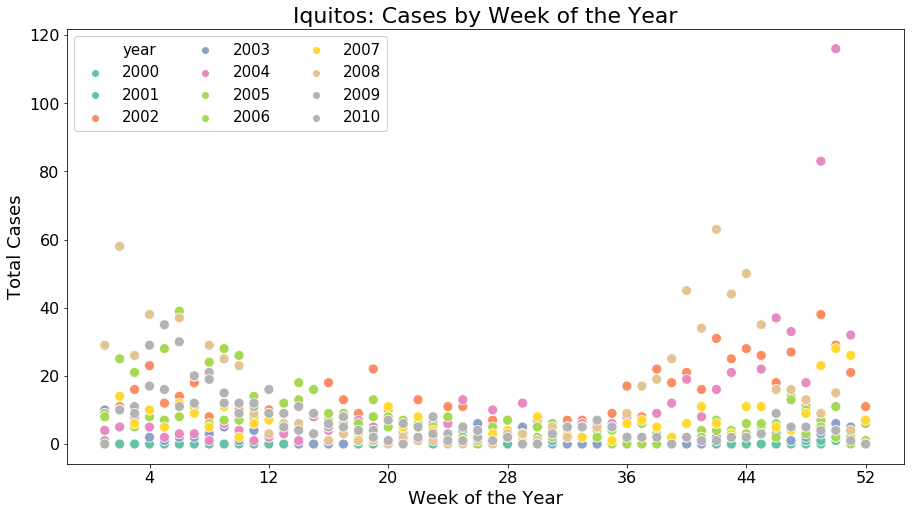

In [6]:
plt.figure(figsize=[15,8])
plt.title('Iquitos: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=iq, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

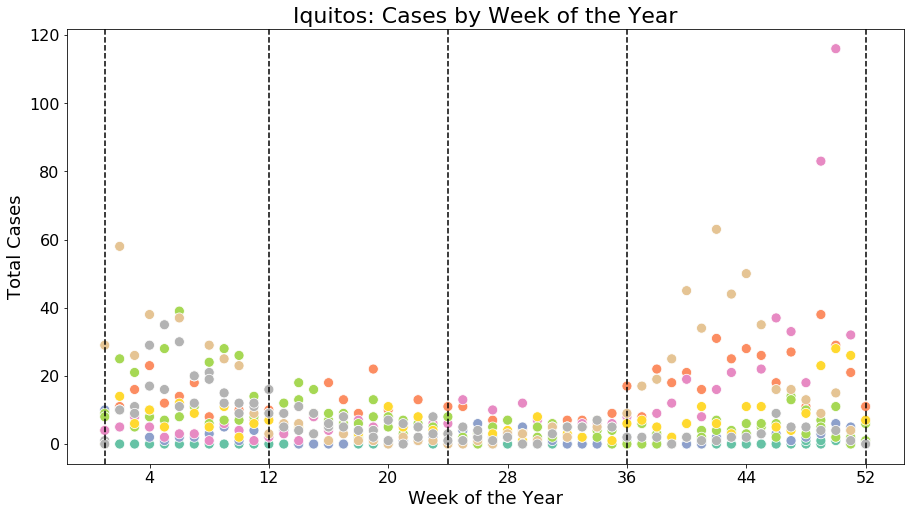

In [10]:
plt.figure(figsize=[15,8])
plt.title('Iquitos: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=iq, palette='Set2',legend=None)

plot_windows = [1,12,24,36,52]
for w in plot_windows:
    plt.axvline(w, linestyle='--',color='black')
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

In [7]:
#Fill nas with interpolation
iq = iq.interpolate(method='linear')
#Replace week 53 with week 52
iq.loc[:,'weekofyear'] = np.where(iq.weekofyear > 52, 52, iq.weekofyear)

## No feature Engineering besides interpolated nans and a week correction

In [9]:
def examine(y_pred, y_test):
    c = pd.DataFrame({
        'y' : y_test,
        'p' : y_pred
     })
    c = c.sort_index() # check this?
    plt.figure(figsize=[15,4])
    plt.plot(c.y, color='green')
    plt.plot(c.p, color='red')
    plt.show()

In [10]:
X = iq.drop(['week_start_date', 'total_cases', 'city', 'year', 'weekofyear'], axis=1)
y = iq.total_cases

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(364, 20)
(156, 20)


####  Linear Regression

In [10]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-5.61935653 -7.61853388 -7.17287889]
6.135054547377133


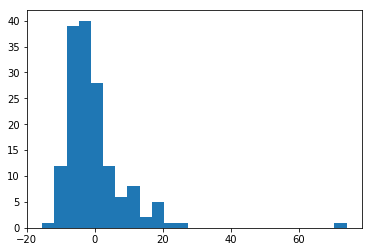

In [12]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

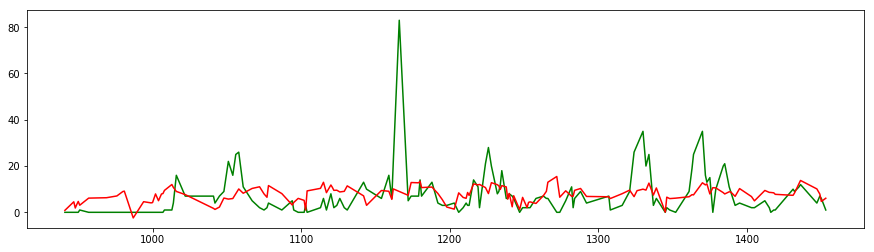

In [13]:
examine(y_pred, y_test)

### Random Forest Regressor

In [14]:
rfr = RandomForestRegressor(max_depth=20, n_estimators=50, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

7.069294871794871
[-6.74692308 -6.59634615 -8.13692308]


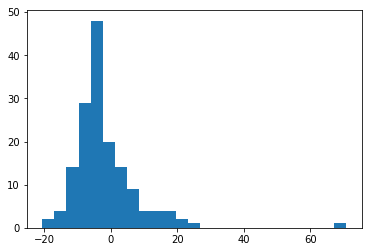

In [15]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

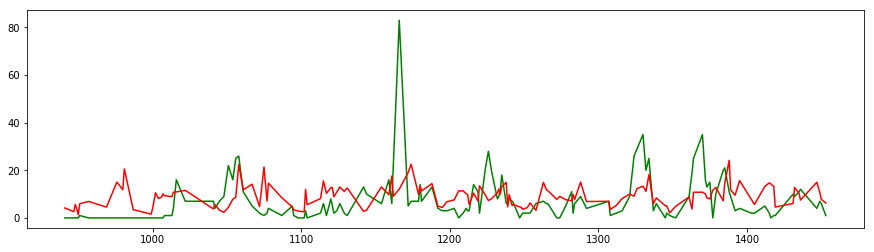

In [16]:
examine(y_pred, y_test)

### KNN Regressor

In [17]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.750669883157231
[-5.59707006 -7.45455319 -7.67375005]


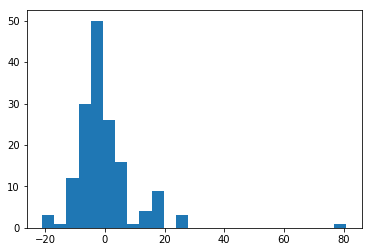

In [18]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

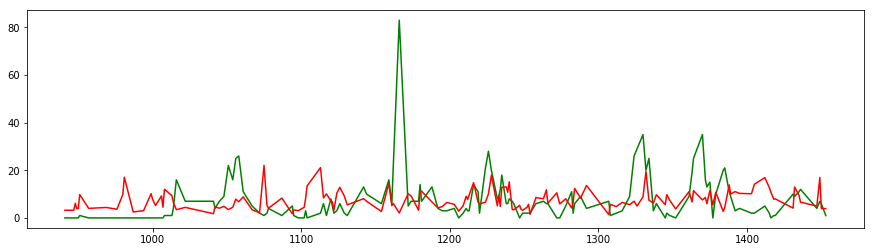

In [19]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [20]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=3,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

5.707581215531445
[-5.71899372 -5.42690361 -7.8105278 ]


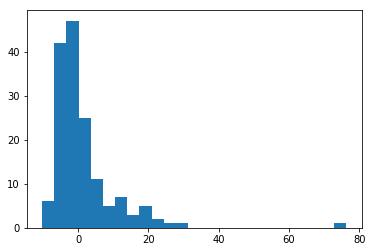

In [21]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

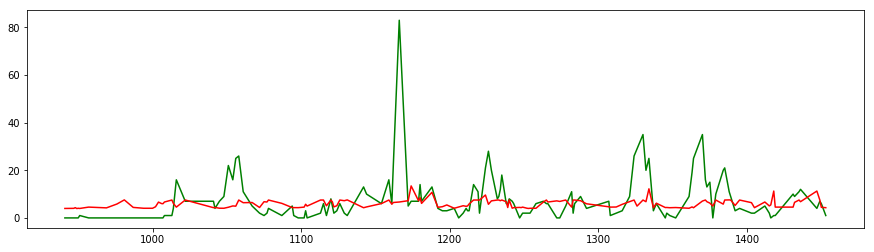

In [22]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [24]:
smX_train = X_train.copy()
smX_train['total_cases'] = y_train
smX_test = X_test.copy()
smX_test['total_cases'] = y_test

In [25]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm'

In [26]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [27]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

6.012820512820513

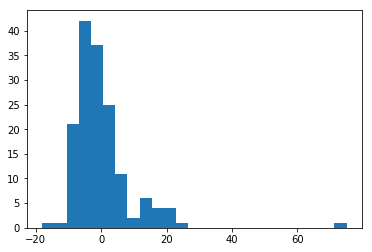

In [28]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

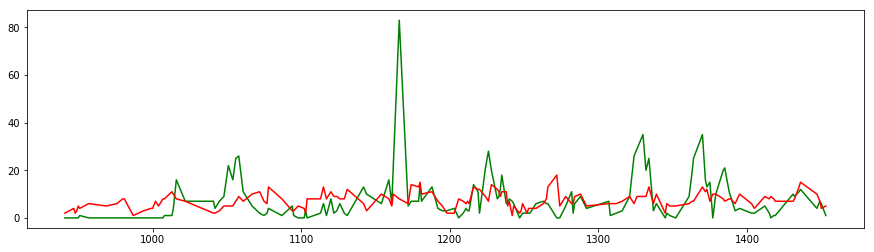

In [29]:
examine(predictions, y_test)

# Feature Engineering 

In [30]:
[x for x in iq.columns]

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

### Temperature

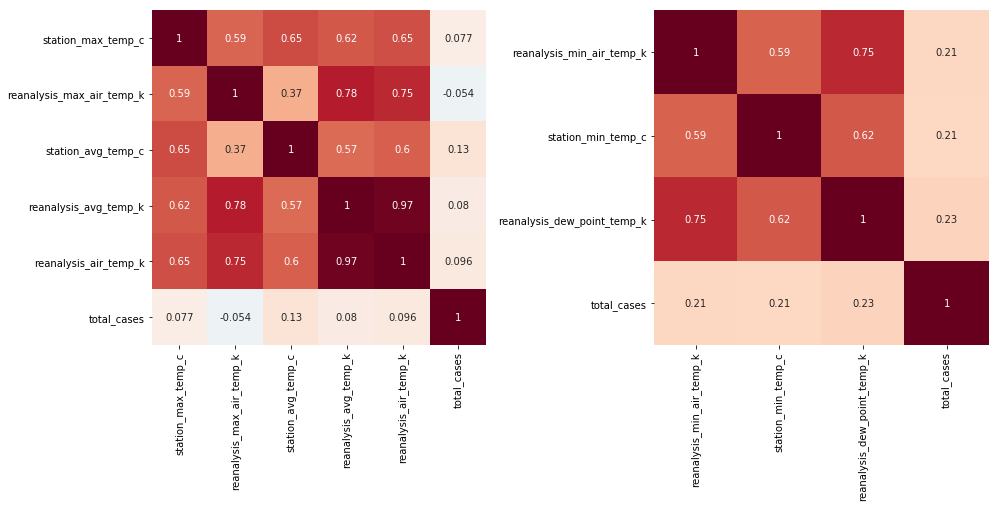

In [50]:
tempshigh = iq[['station_max_temp_c',
            'reanalysis_max_air_temp_k',
            'station_avg_temp_c',
            'reanalysis_avg_temp_k',
            'reanalysis_air_temp_k',
           'total_cases', ]].copy()

tempslow = iq[[ 'reanalysis_min_air_temp_k',
     'station_min_temp_c',
     'reanalysis_dew_point_temp_k',
     'total_cases']].copy()
plt.figure(figsize=[15,15])
plt.subplot(1,2,1)
sns.heatmap(tempshigh.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cbar=False, cmap='RdBu_r', annot=True)
plt.subplot(1,2,2)
sns.heatmap(tempslow.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cbar=False, cmap='RdBu_r', annot=True)
plt.subplots_adjust(wspace=.5)
plt.show()

In [44]:
temps['weekofyear'] = iq.weekofyear

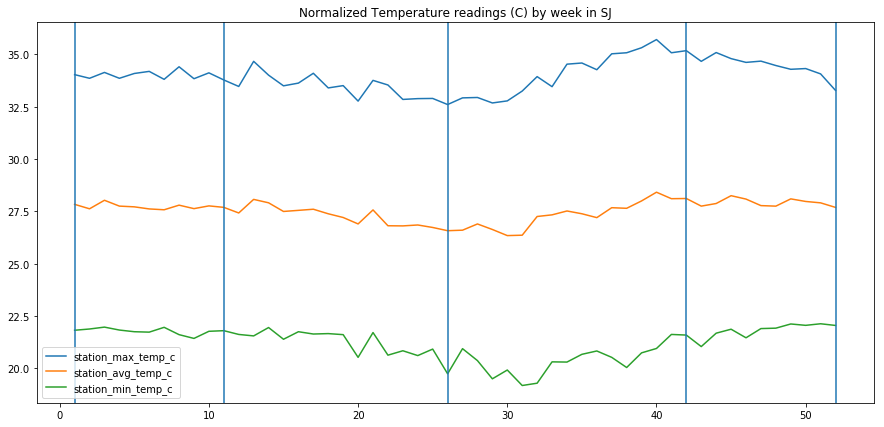

In [45]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (C) by week in SJ')
for i in ['station_max_temp_c','station_avg_temp_c','station_min_temp_c']:
    if i != 'total_cases' and i != 'weekofyear':
        plt.plot(temps.groupby('weekofyear')[i].mean(),
            label=i)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])

plt.legend()
plt.show()

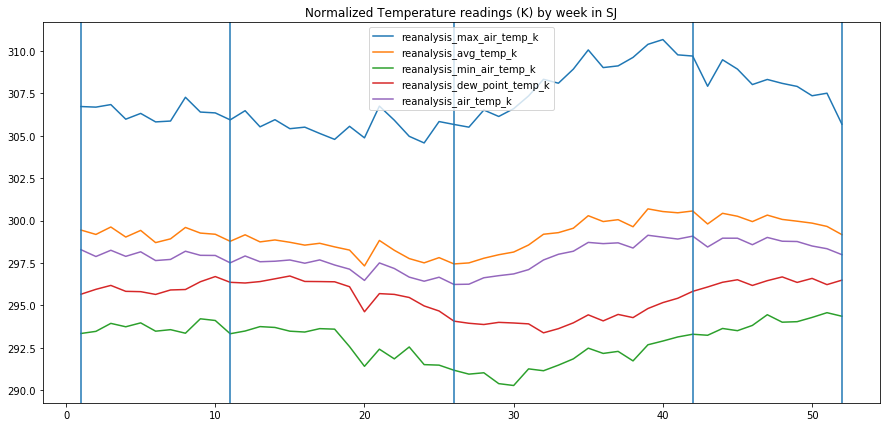

In [46]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (K) by week in SJ')
for i in ['reanalysis_max_air_temp_k',
            'reanalysis_avg_temp_k',
            'reanalysis_min_air_temp_k',
            'reanalysis_dew_point_temp_k',
            'reanalysis_air_temp_k',]:
    if i != 'total_cases' and i != 'weekofyear':
        plt.plot(temps.groupby('weekofyear')[i].mean(),
            label=i)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])

plt.legend()
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline(T, power, k=3) #BSpline object
power_smooth = spl(xnew)

plt.plot(xnew,power_smooth)
plt.show()

####  Conclusion: Temperature:

I will keep those with higher than .1 correlations with total cases:

In [56]:
iqfeats = iq[['city', 'year', 'weekofyear', 'total_cases', 'station_avg_temp_c',
              'reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k',]].copy()

In [55]:
tempslow.columns

Index(['reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'total_cases'],
      dtype='object')

#### Seasons

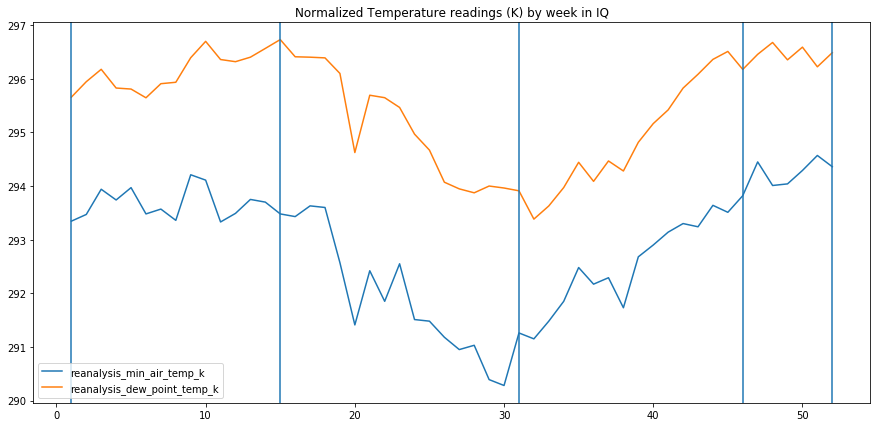

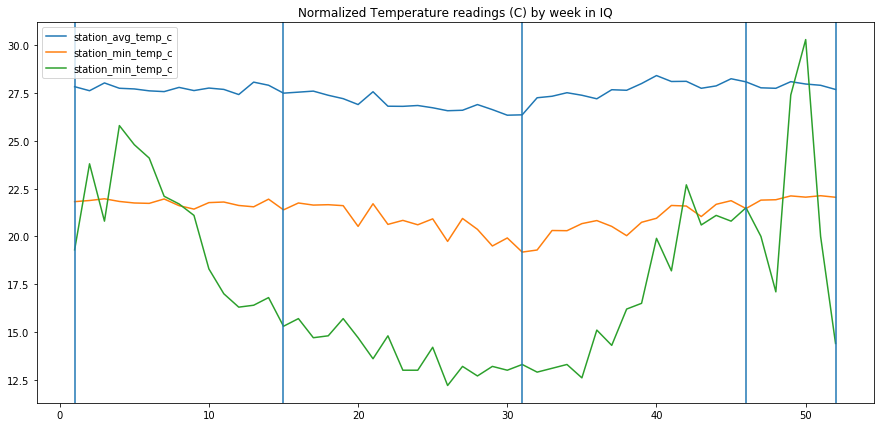

In [73]:
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (K) by week in IQ')
for i in ['reanalysis_min_air_temp_k',
            'reanalysis_dew_point_temp_k']:
    plt.plot(temps.groupby('weekofyear')[i].mean(),
            label=i)
    
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[15])
plt.axvline(x=[31])
plt.axvline(x=[46])
plt.axvline(x=[52])

plt.legend()
plt.show()
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings (C) by week in IQ')
for i in ['station_avg_temp_c',
        'station_min_temp_c']:
    plt.plot(temps.groupby('weekofyear')[i].mean(),
            label=i)
#Scale output variable to overlay visually, change to double axes!!
plt.plot(temps.groupby('weekofyear')['total_cases'].mean()+10,
            label=i)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[15])
plt.axvline(x=[31])
plt.axvline(x=[46])
plt.axvline(x=[52])

plt.legend()
plt.show()

In [75]:
cutoffs = [15, 31, 46]
iqfeats['fall'] = np.where((iqfeats.weekofyear<cutoffs[0]), 1, 0)

iqfeats['winter'] = np.where((iqfeats.weekofyear>=cutoffs[0]) &
                           (iqfeats.weekofyear<cutoffs[1]), 1, 0)
iqfeats['spring'] = np.where((iqfeats.weekofyear>=cutoffs[1]) &
                           (iqfeats.weekofyear<cutoffs[2]), 1, 0)
iqfeats['summer'] = np.where((iqfeats.weekofyear>=cutoffs[2]), 1, 0)

In [77]:
iqfeats.corr()['total_cases']

year                           0.179451
weekofyear                    -0.011783
total_cases                    1.000000
station_avg_temp_c             0.133989
reanalysis_min_air_temp_k      0.211679
station_min_temp_c             0.206817
reanalysis_dew_point_temp_k    0.229183
fall                           0.170859
winter                        -0.221779
spring                        -0.050837
summer                         0.145336
Name: total_cases, dtype: float64

### Other temperature measurements and humidity

In [78]:
othertemps = ['total_cases','station_diur_temp_rng_c', 'reanalysis_tdtr_k','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg']
iq[othertemps].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg
total_cases,1.000000,-0.036134,-0.132191,0.129486,0.235218
station_diur_temp_rng_c,-0.036134,1.000000,0.557090,-0.550234,-0.231201
reanalysis_tdtr_k,-0.132191,0.557090,1.000000,-0.895984,-0.593731
reanalysis_relative_humidity_percent,0.129486,-0.550234,-0.895984,1.000000,0.722881
reanalysis_specific_humidity_g_per_kg,0.235218,-0.231201,-0.593731,0.722881,1.000000


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


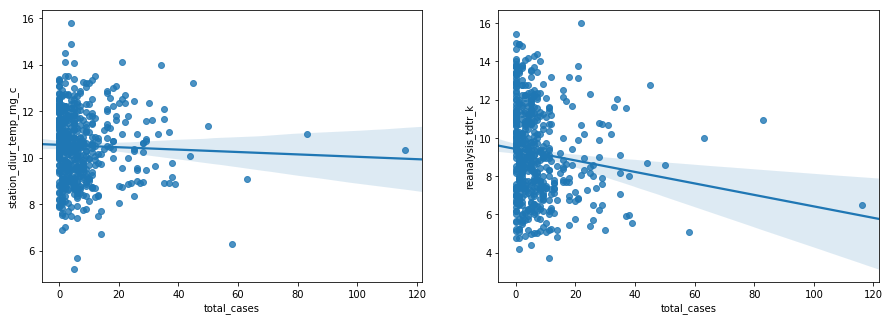

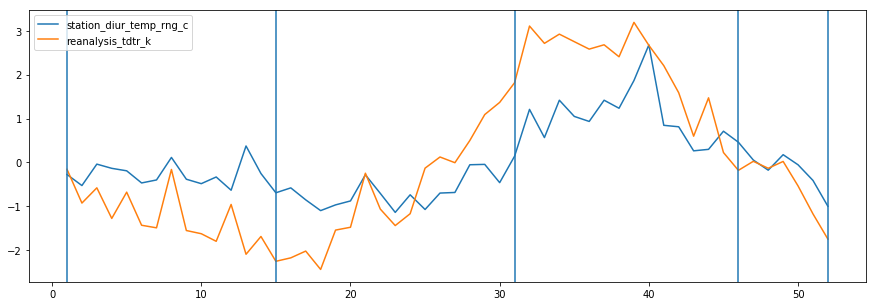

In [80]:
v = 'station_diur_temp_rng_c'
v2 = 'reanalysis_tdtr_k'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(122)
sns.regplot(iq.total_cases, iq[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear')[v].mean() - 
                 iq[v].mean(),
            label=v)

plt.plot(iq.groupby('weekofyear')[v2].mean() - 
                 iq[v2].mean(),
            label=v2)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[15])
plt.axvline(x=[31])
plt.axvline(x=[46])
plt.axvline(x=[52])
plt.legend()
plt.show()

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


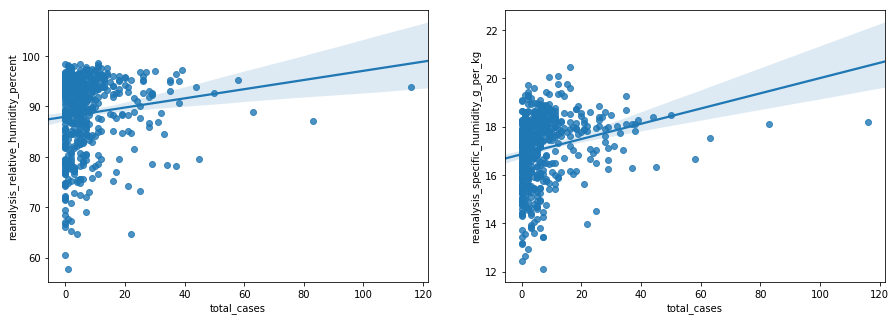

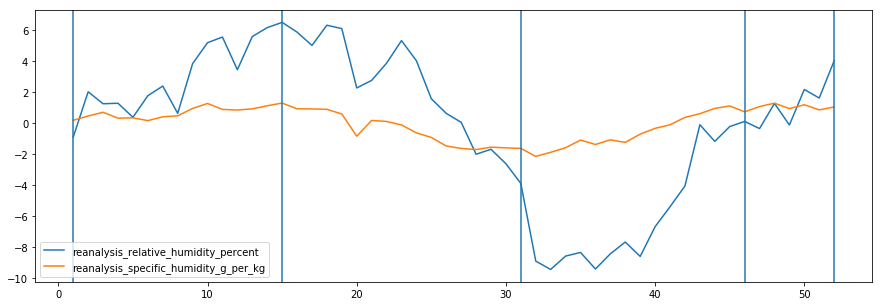

In [82]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(122)
sns.regplot(iq.total_cases, iq[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear')[v].mean() - 
                 iq[v].mean(),
            label=v)

plt.plot(iq.groupby('weekofyear')[v2].mean() - 
                 iq[v2].mean(),
            label=v2)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[15])
plt.axvline(x=[31])
plt.axvline(x=[46])
plt.axvline(x=[52])
plt.legend()
plt.show()

#### Conclusion: Humidity and temperature range

I will include the higher correlation in each category

In [84]:
iqfeats.loc[:,'reanalysis_tdtr_k'] = iq['reanalysis_tdtr_k']
iqfeats.loc[:,'reanalysis_specific_humidity_g_per_kg'] = iq['reanalysis_specific_humidity_g_per_kg']

In [85]:
iqfeats.corr()['total_cases']

year                                     0.179451
weekofyear                              -0.011783
total_cases                              1.000000
station_avg_temp_c                       0.133989
reanalysis_min_air_temp_k                0.211679
station_min_temp_c                       0.206817
reanalysis_dew_point_temp_k              0.229183
fall                                     0.170859
winter                                  -0.221779
spring                                  -0.050837
summer                                   0.145336
reanalysis_tdtr_k                       -0.132191
reanalysis_specific_humidity_g_per_kg    0.235218
Name: total_cases, dtype: float64

### Rain

In [88]:
rain = ['total_cases',
       'precipitation_amt_mm', 
       'reanalysis_precip_amt_kg_per_m2',
       #'reanalysis_sat_precip_amt_mm', # identical to precipitation_amt_mm
       'station_precip_mm']
iq[rain].corr()

,total_cases,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,station_precip_mm
total_cases,1.000000,0.090628,0.101150,0.044568
precipitation_amt_mm,0.090628,1.000000,0.339115,0.374506
reanalysis_precip_amt_kg_per_m2,0.101150,0.339115,1.000000,0.154838
station_precip_mm,0.044568,0.374506,0.154838,1.000000


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


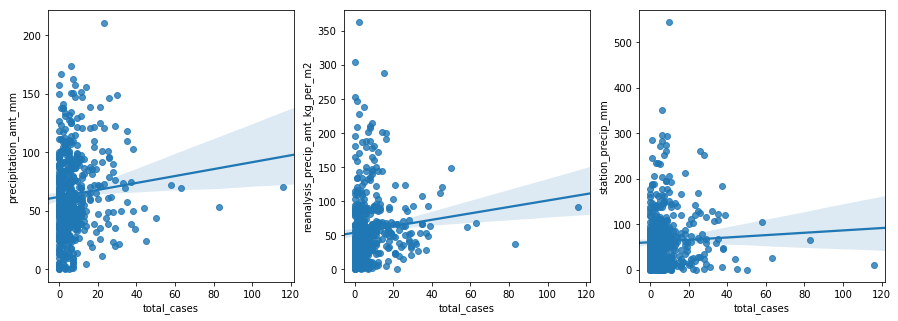

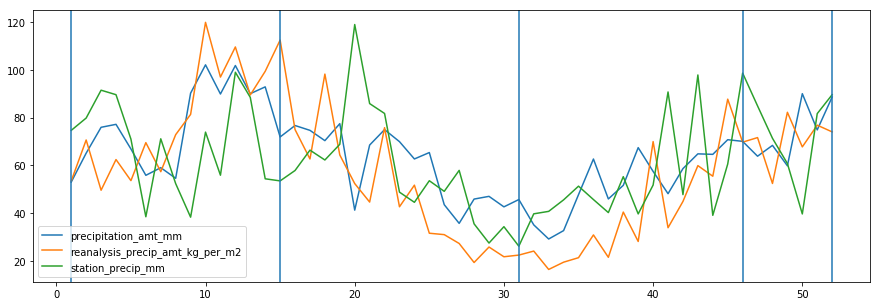

In [89]:
v = 'precipitation_amt_mm'
v2 = 'reanalysis_precip_amt_kg_per_m2'
v3 = 'station_precip_mm'

plt.figure(figsize=[15,5])
plt.subplot(131)
sns.regplot(iq.total_cases, iq[v])
plt.subplot(132)
sns.regplot(iq.total_cases, iq[v2])
plt.subplot(133)
sns.regplot(iq.total_cases, iq[v3])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(iq.groupby('weekofyear')[v].mean(), 
            label=v)
plt.plot(iq.groupby('weekofyear')[v2].mean(),
            label=v2)
plt.plot(iq.groupby('weekofyear')[v3].mean(), 
            label=v3)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[15])
plt.axvline(x=[31])
plt.axvline(x=[46])
plt.axvline(x=[52])
plt.legend()
plt.show()

#### Conclusion: Rain

I will include only the strongest correlated variable, precipitation_amt_mm

In [90]:
iqfeats.loc[:,'precipitation_amt_mm'] = iq['precipitation_amt_mm']
iqfeats.corr()['total_cases']

year                                     0.179451
weekofyear                              -0.011783
total_cases                              1.000000
station_avg_temp_c                       0.133989
reanalysis_min_air_temp_k                0.211679
station_min_temp_c                       0.206817
reanalysis_dew_point_temp_k              0.229183
fall                                     0.170859
winter                                  -0.221779
spring                                  -0.050837
summer                                   0.145336
reanalysis_tdtr_k                       -0.132191
reanalysis_specific_humidity_g_per_kg    0.235218
precipitation_amt_mm                     0.090628
Name: total_cases, dtype: float64

### Vegetation

In [91]:
vegs = ['total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']
iq[vegs].corr()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
total_cases,1.000000,0.020794,-0.009952,-0.040643,0.032812
ndvi_ne,0.020794,1.000000,0.764200,0.769360,0.842922
ndvi_nw,-0.009952,0.764200,1.000000,0.644541,0.765389
ndvi_se,-0.040643,0.769360,0.644541,1.000000,0.715192
ndvi_sw,0.032812,0.842922,0.765389,0.715192,1.000000


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


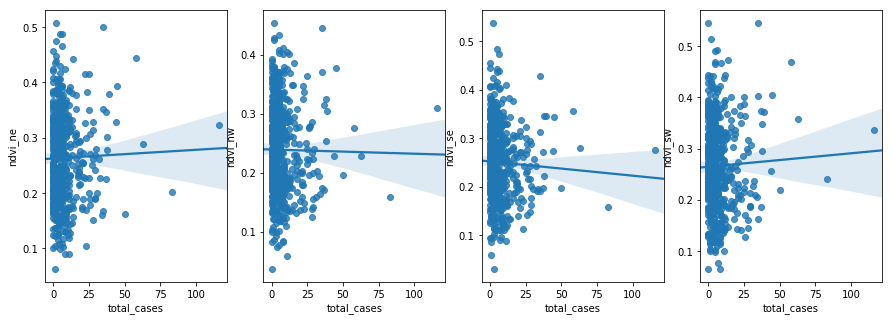

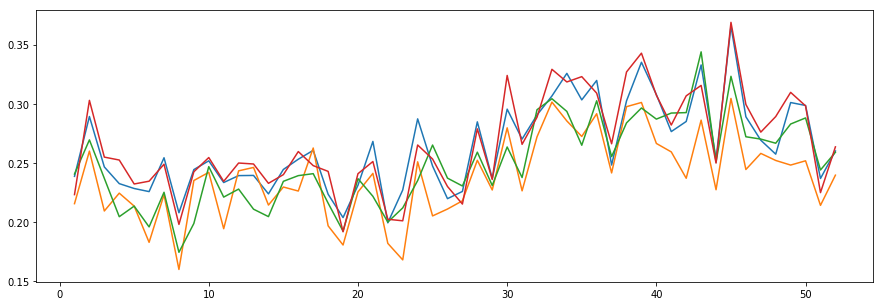

In [92]:
plt.figure(figsize=[15,5])
for i,col in enumerate(vegs[1:]):
    plt.subplot(1,4,i+1)
    sns.regplot(iq.total_cases, iq[col])
plt.show()

plt.figure(figsize=[15,5])
for v in vegs[1:]:
    plt.plot(iq.groupby('weekofyear')[v].mean(), 
            label=v)
plt.show()

#### Conclusion: Vegetation
Excluded

# Modelling with chosen features

In [93]:
iqfeats.head()

,city,year,weekofyear,total_cases,station_avg_temp_c,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_dew_point_temp_k,fall,winter,spring,summer,reanalysis_tdtr_k,reanalysis_specific_humidity_g_per_kg,precipitation_amt_mm
936,iq,2000,26,0,26.400000,293.1,20.7,295.184286,0,1,0,0,8.928571,16.651429,25.41
937,iq,2000,27,0,26.900000,291.1,20.8,295.358571,0,1,0,0,10.314286,16.862857,60.61
938,iq,2000,28,0,26.800000,292.6,20.7,295.622857,0,1,0,0,7.385714,17.120000,55.52
939,iq,2000,29,0,25.766667,288.6,14.7,292.797143,0,1,0,0,9.114286,14.431429,5.60
940,iq,2000,30,0,26.600000,291.5,19.1,293.957143,0,1,0,0,9.500000,15.444286,62.76


In [95]:
X = iqfeats.drop(['total_cases', 'city', 'year', 'weekofyear', 'spring'], axis=1)
X2 = iqfeats.drop(['total_cases', 'city', 'year', 'weekofyear'], axis=1) #for regularizing techniques
y = iqfeats.total_cases

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(364, 10)
(156, 10)


#### Linear Regression

In [96]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-7.55177078 -7.30681159 -6.98261317]
6.397946043936591


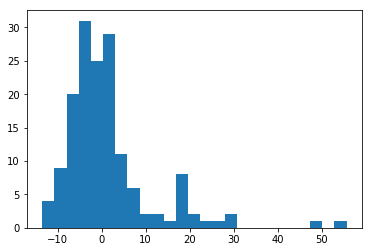

In [97]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

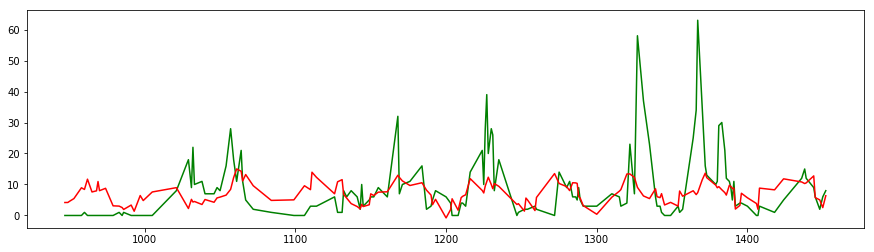

In [98]:
examine(y_pred, y_test)

### Random Forest Regressor

In [99]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.607419871794873
[-7.8175     -7.48942308 -7.10567308]


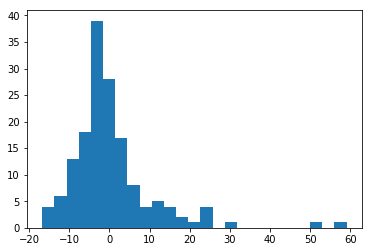

In [100]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

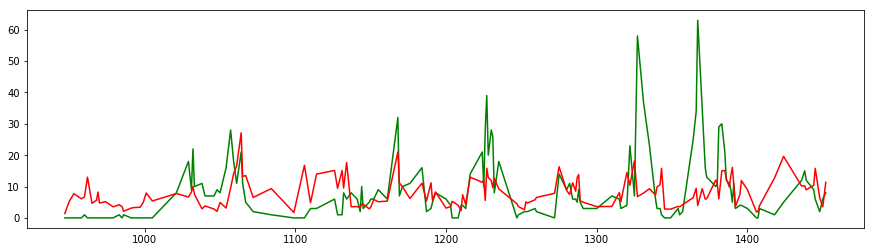

In [101]:
examine(y_pred, y_test)

### KNN Regressor

In [102]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.935716643579588
[-8.37742532 -7.63563683 -7.5474076 ]


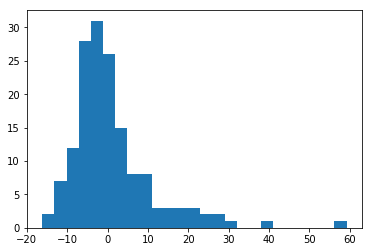

In [103]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

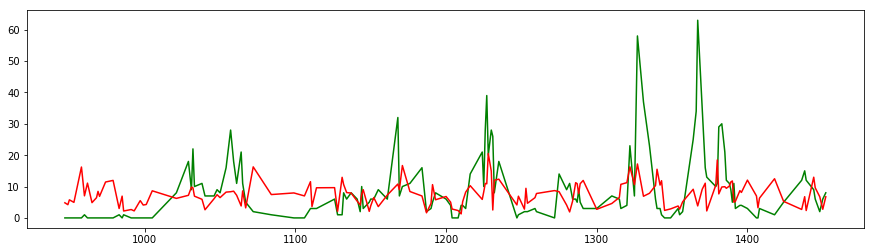

In [104]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [105]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=2,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.359870288336548
[-7.92391964 -6.59187796 -5.89236493]


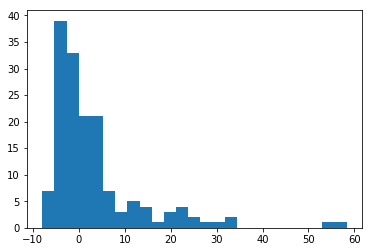

In [106]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

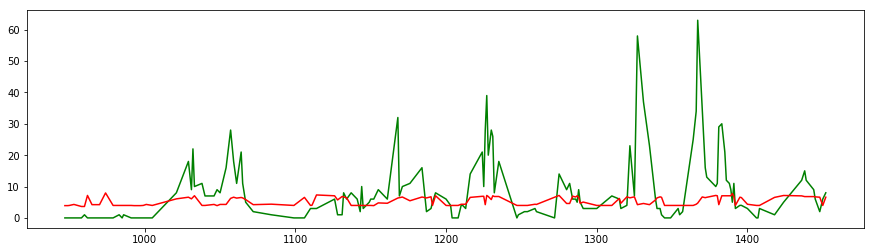

In [107]:
examine(y_pred, y_test)

###  Support Vector Regression

In [108]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.694724389919878
[-8.08663597 -6.18399224 -6.12983501]


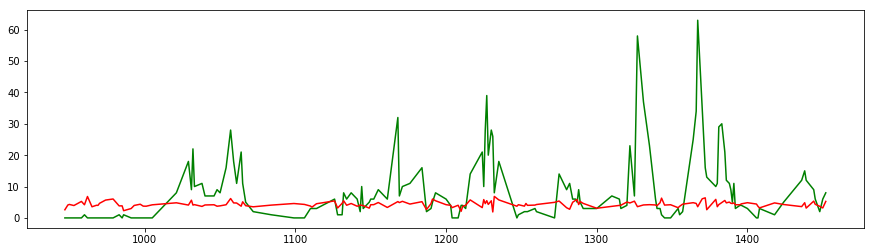

In [109]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [110]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [111]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ station_avg_temp_c + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_dew_point_temp_k + fall + winter + summer + reanalysis_tdtr_k + reanalysis_specific_humidity_g_per_kg + precipitation_amt_mm'

In [112]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [113]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

6.378205128205129

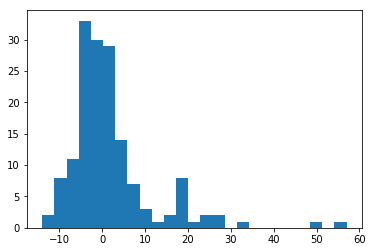

In [114]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

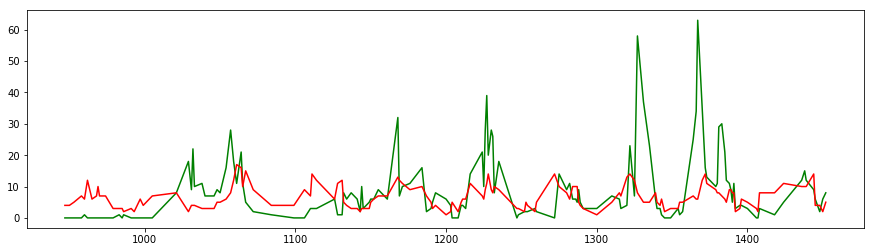

In [115]:
examine(predictions, y_test)

## Adding a TON of lagged features

In [120]:
iqfeats.columns

Index(['city', 'year', 'weekofyear', 'total_cases', 'station_avg_temp_c',
       'reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'fall', 'winter', 'spring', 'summer',
       'reanalysis_tdtr_k', 'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm'],
      dtype='object')

In [121]:
iqshiftedfeats = iqfeats[['city', 'year', 'weekofyear', 'total_cases',
                      'winter', 'spring', 'summer', 'fall']].copy()
for i in ['station_avg_temp_c',
       'reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k', 
       'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm']:
    iqshiftedfeats[i] = iqfeats[i]
    iqshiftedfeats[i+'_1lag'] = iqfeats[i].shift(-1)
    iqshiftedfeats[i+'_2lag'] = iqfeats[i].shift(-2)
    iqshiftedfeats[i+'_3lag'] = iqfeats[i].shift(-3)

iqshiftedfeats = iqshiftedfeats.fillna(method='ffill')
iqshiftedfeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 36 columns):
city                                          520 non-null object
year                                          520 non-null int64
weekofyear                                    520 non-null int64
total_cases                                   520 non-null int64
winter                                        520 non-null int32
spring                                        520 non-null int32
summer                                        520 non-null int32
fall                                          520 non-null int32
station_avg_temp_c                            520 non-null float64
station_avg_temp_c_1lag                       520 non-null float64
station_avg_temp_c_2lag                       520 non-null float64
station_avg_temp_c_3lag                       520 non-null float64
reanalysis_min_air_temp_k                     520 non-null float64
reanalysis_min_air_temp_k_1lag      

In [122]:
X = iqshiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear', 'winter'], axis=1)
X2 = iqshiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear'], axis=1) #for regularizing techniques
y = iqshiftedfeats.total_cases

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(364, 31)
(156, 31)


#### Linear Regression

In [124]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-8.32280916 -8.71717289 -9.5040364 ]
6.397825919458035


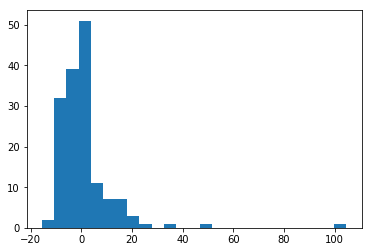

In [125]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

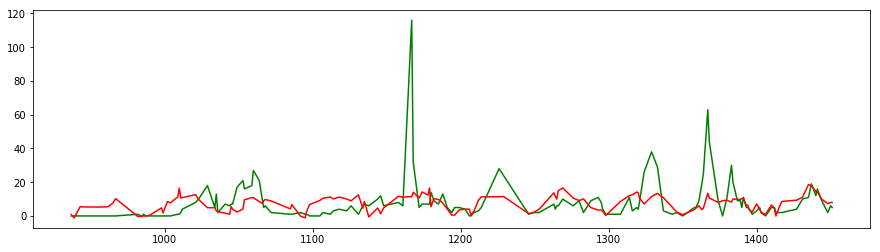

In [126]:
examine(y_pred, y_test)

### Random Forest Regressor

In [127]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mse')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.868044871794871
[-7.34346154 -9.42855769 -7.66346154]


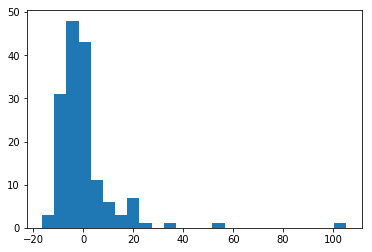

In [128]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

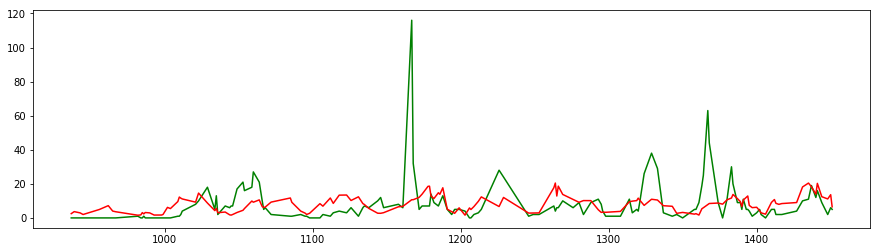

In [129]:
examine(y_pred, y_test)

In [130]:
[(X_train.columns[i], rfr.feature_importances_[i]) for i in range(len(X_train.columns))]

[('spring', 0.006679347904313383),
 ('summer', 0.0017091068262801892),
 ('fall', 0.005917667227316626),
 ('station_avg_temp_c', 0.058317307853800765),
 ('station_avg_temp_c_1lag', 0.040363096970837925),
 ('station_avg_temp_c_2lag', 0.026347822972348656),
 ('station_avg_temp_c_3lag', 0.022972756245519737),
 ('reanalysis_min_air_temp_k', 0.027402117271346414),
 ('reanalysis_min_air_temp_k_1lag', 0.025637764222862156),
 ('reanalysis_min_air_temp_k_2lag', 0.018563299876353447),
 ('reanalysis_min_air_temp_k_3lag', 0.023285718062455475),
 ('station_min_temp_c', 0.023791545595133953),
 ('station_min_temp_c_1lag', 0.028437196633958287),
 ('station_min_temp_c_2lag', 0.03810324355493954),
 ('station_min_temp_c_3lag', 0.018858387124005296),
 ('reanalysis_dew_point_temp_k', 0.023682372855732964),
 ('reanalysis_dew_point_temp_k_1lag', 0.02139711517175421),
 ('reanalysis_dew_point_temp_k_2lag', 0.028170464795568916),
 ('reanalysis_dew_point_temp_k_3lag', 0.06426672211365529),
 ('reanalysis_tdtr_k', 

### KNN Regressor

In [131]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.532041096892693
[-6.0640895  -8.20217184 -7.89577382]


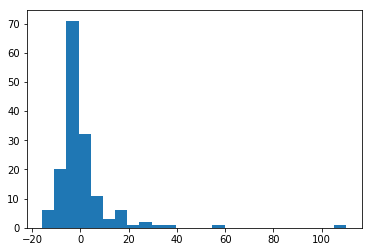

In [132]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

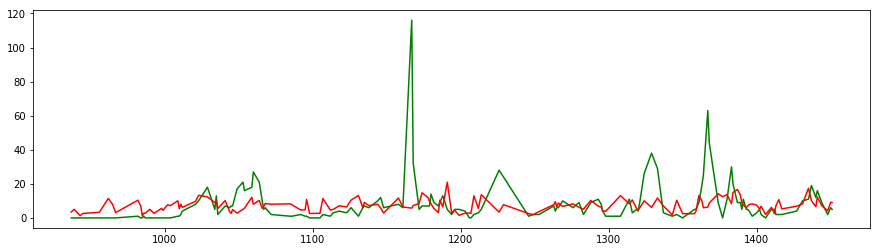

In [133]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [134]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=4,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

6.178401194394765
[-5.61365255 -8.15029366 -6.15370825]


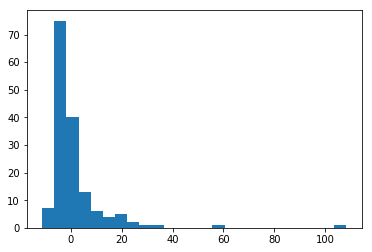

In [135]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

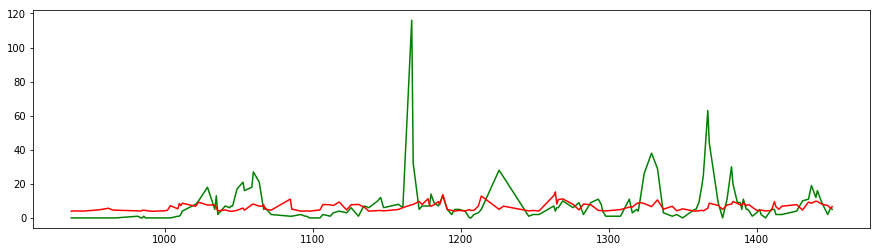

In [136]:
examine(y_pred, y_test)

###  Support Vector Regression

In [137]:
svr = SVR(gamma='scale', kernel='linear')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

5.8335982407432905
[-5.5365194  -7.98431865 -5.72979855]


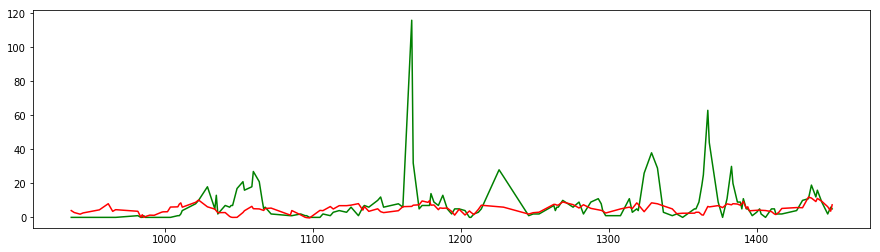

In [138]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [139]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [140]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ spring + summer + fall + station_avg_temp_c + station_avg_temp_c_1lag + station_avg_temp_c_2lag + station_avg_temp_c_3lag + reanalysis_min_air_temp_k + reanalysis_min_air_temp_k_1lag + reanalysis_min_air_temp_k_2lag + reanalysis_min_air_temp_k_3lag + station_min_temp_c + station_min_temp_c_1lag + station_min_temp_c_2lag + station_min_temp_c_3lag + reanalysis_dew_point_temp_k + reanalysis_dew_point_temp_k_1lag + reanalysis_dew_point_temp_k_2lag + reanalysis_dew_point_temp_k_3lag + reanalysis_tdtr_k + reanalysis_tdtr_k_1lag + reanalysis_tdtr_k_2lag + reanalysis_tdtr_k_3lag + reanalysis_specific_humidity_g_per_kg + reanalysis_specific_humidity_g_per_kg_1lag + reanalysis_specific_humidity_g_per_kg_2lag + reanalysis_specific_humidity_g_per_kg_3lag + precipitation_amt_mm + precipitation_amt_mm_1lag + precipitation_amt_mm_2lag + precipitation_amt_mm_3lag'

In [141]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [142]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

6.391025641025641

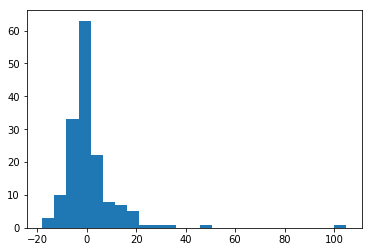

In [143]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

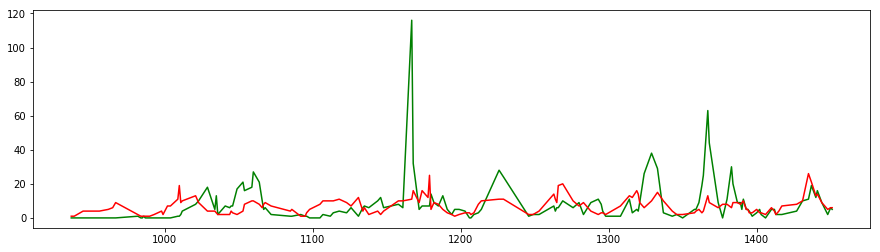

In [144]:
examine(predictions, y_test)